In [18]:
import numpy as np
import pandas as pd
import math
import time
import re
import os
from skimage import util
from scipy.io import wavfile
from scipy import signal
from scipy import stats
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def create_slice_from_wav(file_path, slice_len, step_size):
    """Creates small slices from wav file. Slice_len (use sampling frequency to convert to ms). 
    Step_size is amount of overlap between each slice."""
    
    #read in wav file
    samp_freq, sig_data = wavfile.read(file_path)
    sig_data = sig_data[0:150000000]
    print('Sampling frequency: ' + str(samp_freq))
    
    #determine number of samples and length
    n_samples = sig_data.shape[0]
    print('Number of samples: ' + str(n_samples))
    sig_len = n_samples/samp_freq
    print('Length: ' + str(sig_len) + ' sec')
    
    #create slices 
    M = slice_len
    steps = int(M*step_size)
    slices = util.view_as_windows(sig_data, window_shape=(M,), step=steps)
    print(f'Audio shape: {sig_data.shape}, Sliced audio shape: {slices.shape}')
    
    return samp_freq, sig_data, slices, steps

In [3]:
def create_spec_from_slice_array(slices, spec_window=128, NFFT=512, samp_freq=250000, steps=5625):
    """Creates fft spectrogram from slice. spec_window is length of each segment (nperseg).
    NFFT is length of the FFT used (nfft). samp_freq is sampling frequency (in Hz) of slice (fs).
    steps is step size between slices"""
    #create spectrogram from each slice
    
    spec_slices = {}
    samp_freq_kHz = samp_freq/1000

    for i in range(slices.shape[0]): 
        if i % 5000 == 0:
            print(i)
            
        #spectrogram
        freqs_spec, times, Sx = signal.spectrogram(slices[i,:], fs=samp_freq, nperseg = spec_window, nfft = NFFT)
    
        time_stamp = i*steps / samp_freq_kHz
    
        #store as dic
        spec_slices[time_stamp] = Sx

    return spec_slices, freqs_spec, times


In [4]:
def create_xarray_dataset_from_dic(dic, freqs_spec, times):
    """Creates an xarray.Dataset object from a dictionary input."""
    
    slices_combined = {}
    
    for key, fft_slice in dic.items():
        slices_combined[key] = xr.DataArray(fft_slice, dims = ('freq', 'times'), coords = {'freq': freqs_spec, 'times': times})
    slices_Dataset = xr.Dataset(slices_combined).to_array(dim = 'slices')
    
    return slices_Dataset

Find path names for each wav file corresponding to annotated data

In [5]:
wav_dir_path = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/18.12.07_CPA_pair_3x'

In [6]:
path_names = []
files = os.listdir(wav_dir_path)
for file in files: 
        path_names.append(wav_dir_path + "/" + file)

path_names

['C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/18.12.07_CPA_pair_3x/533.wav',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/18.12.07_CPA_pair_3x/534.wav',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/18.12.07_CPA_pair_3x/535.wav',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/18.12.07_CPA_pair_3x/542.wav',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/18.12.07_CPA_pair_3x/543.wav',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/18.12.07_CPA_pair_3x/554.wav',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/18.12.07_CPA_pair_3x/555.wav',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/18.12.07_CPA_pair_3x/559.wav',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/18.12.07_CPA_pair_3x/600.wav']

In [7]:
#select animal to process (need to process individually due to memory contraints)
path = path_names[2]
name = re.search("\d\d\d", path).group(0)

#process wav file of animal corresponding to annotations
print(str('Begin processing animal # ' + name))

#create slices
start = time.time()
samp_freq, sig_data, slices, steps = create_slice_from_wav(path, 6250, 0.9)
end = time.time()
print(str('Slices created in ' + str(end - start) + '  seconds'))

#create spectrograms
start = time.time()
spec_slices, freqs_spec, times = create_spec_from_slice_array(slices, spec_window=128, NFFT=512, samp_freq=250000, steps=5625)
end = time.time()
print(str('Spectrograms created in ' + str(end - start) + '  seconds'))

#create xarray Dataset
start = time.time()
slices_Dataset = create_xarray_dataset_from_dic(spec_slices, freqs_spec, times)
end = time.time()
print(str('xarray created in ' + str(end - start) + '  seconds'))

#save
start = time.time()
slices_Dataset.to_netcdf(name + '_xr_Dataset.nc')
end = time.time()
print(str('xarray saved in ' + str(end - start) + '  seconds'))

Begin processing animal # 535
Sampling frequency: 250000
Number of samples: 150000000
Length: 600.0 sec
Audio shape: (150000000,), Sliced audio shape: (26666, 6250)
Slices created in 1.5151958465576172  seconds
0
5000
10000
15000
20000
25000
Spectrograms created in 17.953319787979126  seconds
xarray created in 34.47315192222595  seconds
xarray saved in 51.76563835144043  seconds


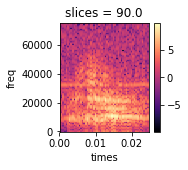

In [43]:
plt.figure(figsize=(2,2))
xr.ufuncs.log(slices_Dataset.sel(freq=slice(0,75000))[4,:,:]).plot(cmap='magma')
plt.show()
#ax.set_aspect("equal")